In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import hdbscan

In [5]:
def detect_vendor_invoice_anomalies_hdbscan(df, 
                                          invoice_column='fldInvoiceAmount', 
                                          vendor_column='fldVendorNo',
                                          min_cluster_size=3,
                                          min_samples=None):
    """
    Detect invoice amount anomalies for each vendor using HDBSCAN
    
    Parameters:
    - df: Input DataFrame
    - invoice_column: Column containing invoice amounts
    - vendor_column: Column containing vendor identifiers
    - min_cluster_size: Minimum size for a cluster
    - min_samples: Number of samples in a neighborhood for a point to be core
    
    Returns:
    - DataFrame with anomaly annotations
    - Summary of vendor anomalies
    """
    # Create a copy of the DataFrame
    result_df = df.copy()
    
    # Prepare to store vendor-specific anomaly information
    vendor_anomaly_summary = []
    
    # Process each unique vendor
    def process_vendor_anomalies(vendor_data):
        # Skip vendors with insufficient data
        if len(vendor_data) < min_cluster_size:
            return vendor_data.assign(
                HDBSCAN_Anomaly='Insufficient Data',
                HDBSCAN_Cluster=np.nan,
                HDBSCAN_Outlier_Score=np.nan
            )
        
        # Scale invoice amounts
        scaler = StandardScaler()
        scaled_invoices = scaler.fit_transform(vendor_data[[invoice_column]])
        
        try:
            # Apply HDBSCAN
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                prediction_data=True
            )
            
            # Fit the clusterer and get cluster labels
            clusterer.fit(scaled_invoices)
            
            # Get outlier scores and cluster labels
            vendor_data['HDBSCAN_Cluster'] = clusterer.labels_
            vendor_data['HDBSCAN_Outlier_Score'] = clusterer.outlier_scores_
            
            # Mark points as anomalies based on outlier scores
            outlier_threshold = np.percentile(clusterer.outlier_scores_, 90)  # Adjustable threshold
            vendor_data['HDBSCAN_Anomaly'] = np.where(
                vendor_data['HDBSCAN_Outlier_Score'] > outlier_threshold,
                'Yes',
                'No'
            )
            
            # Prepare vendor summary
            anomaly_count = (vendor_data['HDBSCAN_Anomaly'] == 'Yes').sum()
            vendor_summary = {
                'VendorNo': vendor_data[vendor_column].iloc[0],
                'TotalTransactions': len(vendor_data),
                'AnomalyCount': anomaly_count,
                'AnomalyPercentage': (anomaly_count / len(vendor_data)) * 100,
                'MeanInvoiceAmount': vendor_data[invoice_column].mean(),
                'StdInvoiceAmount': vendor_data[invoice_column].std(),
                'NumClusters': len(set(clusterer.labels_[clusterer.labels_ != -1]))
            }
            vendor_anomaly_summary.append(vendor_summary)
            
            return vendor_data
            
        except Exception as e:
            print(f"Error processing vendor {vendor_data[vendor_column].iloc[0]}: {e}")
            return vendor_data.assign(
                HDBSCAN_Anomaly='Processing Error',
                HDBSCAN_Cluster=np.nan,
                HDBSCAN_Outlier_Score=np.nan
            )
    
    # Apply vendor-specific anomaly detection
    result_df = result_df.groupby(vendor_column).apply(process_vendor_anomalies).reset_index(drop=True)
    
    # Create vendor anomaly summary DataFrame
    vendor_summary_df = pd.DataFrame(vendor_anomaly_summary)
    
    # Visualization of anomalies
    plt.figure(figsize=(15, 8))
    
    # Main scatter plot
    sns.scatterplot(
        data=result_df[result_df['HDBSCAN_Anomaly'].isin(['Yes', 'No'])],
        x=vendor_column,
        y=invoice_column,
        hue='HDBSCAN_Anomaly',
        palette={'Yes': 'red', 'No': 'green'},
        alpha=0.6
    )
    
    # Add any special cases
    special_cases = result_df[~result_df['HDBSCAN_Anomaly'].isin(['Yes', 'No'])]
    if len(special_cases) > 0:
        sns.scatterplot(
            data=special_cases,
            x=vendor_column,
            y=invoice_column,
            color='gray',
            alpha=0.3,
            label='Insufficient Data/Error'
        )
    
    plt.title("Vendor-Specific Invoice Amount Anomalies (HDBSCAN)")
    plt.xlabel("Vendor Number")
    plt.ylabel("Invoice Amount")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Outlier scores distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=result_df[result_df['HDBSCAN_Outlier_Score'].notna()],
        x=vendor_column,
        y='HDBSCAN_Outlier_Score'
    )
    plt.title("Distribution of Outlier Scores by Vendor")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return result_df, vendor_summary_df

In [7]:
def main():
    # Load the dataset
    df = pd.read_csv("output_with_anomalies.csv")
    
    # Detect vendor-specific invoice amount anomalies using HDBSCAN
    df_with_anomalies, vendor_summary = detect_vendor_invoice_anomalies_hdbscan(
        df,
        min_cluster_size=5,  # Adjust based on your data
        min_samples=None  # Let HDBSCAN determine automatically
    )
    
    # Save results
    df_with_anomalies.to_csv("vendor_specific_hdbscan_anomalies.csv", index=False)
    vendor_summary.to_csv("vendor_hdbscan_anomaly_summary.csv", index=False)
    
    # Print summary statistics
    print("\nVendor Anomaly Summary:")
    print(vendor_summary.describe())
    
    # Print detailed vendor analysis
    print("\nDetailed Vendor Analysis:")
    print(vendor_summary.sort_values('AnomalyPercentage', ascending=False))

C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\hdbscan\hdbscan_.py:1489: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\hdbscan\hdbscan_.py:1489: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\hdbscan\hdbscan_.py:1489: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\hdbscan\hdbscan_.py:1489: RuntimeWarning: invalid value encountered in scalar divide
  self._outlier_scores = outlier_scores(self._condensed_tree)
C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\hdbscan\hdbscan_.py:1489: Runtim

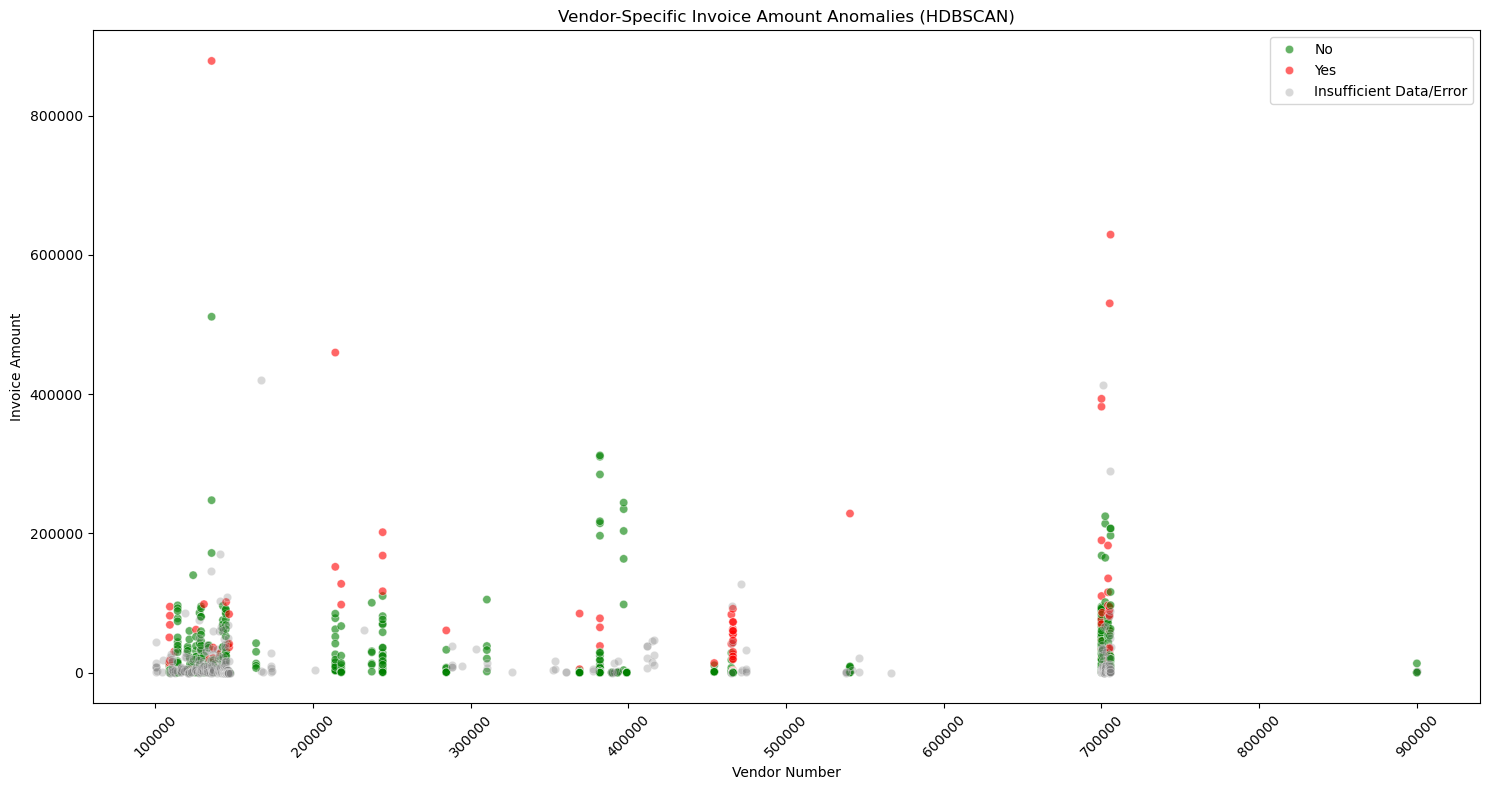

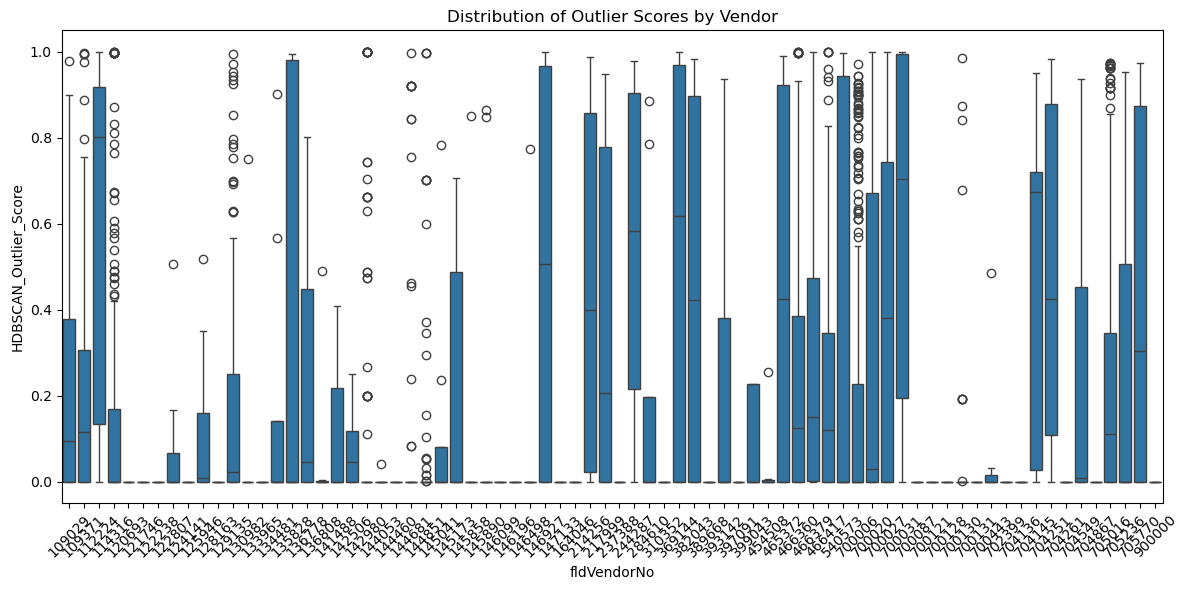


Vendor Anomaly Summary:
            VendorNo  TotalTransactions  AnomalyCount  AnomalyPercentage  \
count      74.000000          74.000000     74.000000          74.000000   
mean   356444.824324          51.594595      2.229730           6.251205   
std    250431.009601         104.900986      5.397989           6.048081   
min    109029.000000           5.000000      0.000000           0.000000   
25%    141742.500000           6.000000      0.000000           0.000000   
50%    227693.500000          10.500000      1.000000           9.090909   
75%    700025.250000          29.750000      2.000000          11.111111   
max    900000.000000         519.000000     33.000000          16.666667   

       MeanInvoiceAmount  StdInvoiceAmount  NumClusters  
count          74.000000         74.000000    74.000000  
mean        19524.096016      28289.416211     2.513514  
std         33405.489051      46716.853264     6.548540  
min             3.766190          2.139153     0.000000  


In [8]:
if __name__ == "__main__":
    main()